## DataFrame benchmarks with object vs. string[pyarrow] data

In [1]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [2]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
from dask.distributed import PipInstall, PackageInstall
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from dask.distributed import performance_report

In [4]:
cluster = coiled.Cluster(
    name="pyarrow-dask-benchmarking",
    n_workers=10,
    package_sync=True,
)

Output()

Output()

In [5]:
client = cluster.get_client()
client

<Client: 'tls://10.0.24.205:8786' processes=10 threads=40, memory=149.32 GiB>

In [10]:
file_paths = "s3://coiled-datasets/mrocklin/nyc-taxi-fhv/"

In [6]:
def get_ddf_object(persist=False):
    ddf = dd.read_parquet(file_paths)
    return ddf.persist() if persist else ddf

In [7]:
def get_ddf_arrow(persist=False):
    with dask.config.set({"dataframe.convert_string": True}):
        ddf2 = dd.read_parquet(file_paths)
        return ddf2.persist() if persist else ddf2

## Memory usage

In [ ]:
client.scale(30)

In [ ]:
client.wait_for_workers(30)

In [17]:
client.restart()

<Client: 'tls://10.0.24.205:8786' processes=10 threads=40, memory=149.32 GiB>

In [9]:
from dask.utils import format_bytes

In [14]:
%%time

ddf = get_ddf_object(True)

CPU times: user 218 ms, sys: 22.5 ms, total: 240 ms
Wall time: 1.12 s


In [15]:
ddf.dtypes

hvfhs_license_num       string[python]
dispatching_base_num    string[python]
originating_base_num    string[python]
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int32
DOLocationID                     int32
trip_miles                     float32
trip_time                        int32
base_passenger_fare            float32
tolls                          float32
bcf                            float32
sales_tax                      float32
congestion_surcharge           float32
airport_fee             string[python]
tips                           float32
driver_pay                     float32
shared_request_flag           category
shared_match_flag             category
access_a_ride_flag            category
wav_request_flag              category
wav_match_flag                category
dtype: object

In [16]:
format_bytes(ddf.hvfhs_license_num.memory_usage(deep=True).compute())

'43.33 GiB'

In [13]:
ddf2 = get_ddf2(True)

In [14]:
format_bytes(ddf2.store_and_fwd_flag.memory_usage(deep=True).compute())

'5.03 GiB'

In [15]:
memory_usage_object = ddf.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_object

0     48.87 MiB
1     48.06 MiB
2     22.95 MiB
3      1.82 MiB
4      2.66 MiB
5      4.19 MiB
6      6.11 MiB
7      7.69 MiB
8     10.23 MiB
9     12.83 MiB
10    11.51 MiB
11    11.15 MiB
12    10.45 MiB
13    10.47 MiB
14    14.69 MiB
15    16.56 MiB
16    19.13 MiB
17    21.62 MiB
18    21.53 MiB
19    21.28 MiB
20    22.61 MiB
21    26.42 MiB
22    26.50 MiB
23    24.52 MiB
24    18.80 MiB
25    22.73 MiB
26    27.68 MiB
27    27.47 MiB
28    27.38 MiB
29    27.15 MiB
30    24.22 MiB
31    24.05 MiB
32    24.29 MiB
33    28.04 MiB
34    24.82 MiB
35    25.94 MiB
dtype: object

In [16]:
memory_usage_string = ddf2.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_string

0     48.87 MiB
1     48.06 MiB
2     22.95 MiB
3      1.82 MiB
4      2.66 MiB
5      4.19 MiB
6      6.11 MiB
7      7.69 MiB
8     10.23 MiB
9     12.83 MiB
10    11.51 MiB
11    11.15 MiB
12    10.45 MiB
13    10.47 MiB
14    14.69 MiB
15    16.56 MiB
16    19.13 MiB
17    21.62 MiB
18    21.53 MiB
19    21.28 MiB
20    22.61 MiB
21    26.42 MiB
22    26.50 MiB
23    24.52 MiB
24    18.80 MiB
25    22.73 MiB
26    27.68 MiB
27    27.47 MiB
28    27.38 MiB
29    27.15 MiB
30    24.22 MiB
31    24.05 MiB
32    24.29 MiB
33    28.04 MiB
34    24.82 MiB
35    25.94 MiB
dtype: object

## Running time

In [17]:
client.restart();

In [18]:
ddf = get_ddf(True)

In [19]:
wait(ddf);

In [20]:
%timeit -r 5 -n 2 ddf.store_and_fwd_flag.unique().compute()

1.46 s ± 102 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [21]:
%timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").count().compute()

2.61 s ± 72.7 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [22]:
%timeit -r 5 -n 2 ddf.store_and_fwd_flag.str.startswith("a").compute()

13.4 s ± 529 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [23]:
%timeit -r 5 -n 2 ddf.store_and_fwd_flag.str.len().compute()

11.3 s ± 405 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [24]:
client.restart();

In [25]:
ddf2 = get_ddf2(True)

In [26]:
wait(ddf2);

In [27]:
%timeit -r 5 -n 2 ddf2.store_and_fwd_flag.unique().compute()

565 ms ± 99.2 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [28]:
%timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").count().compute()

799 ms ± 195 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [29]:
%timeit -r 5 -n 2 ddf2.store_and_fwd_flag.str.startswith("a").compute()

1.58 s ± 111 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [30]:
%timeit -r 5 -n 2 ddf2.store_and_fwd_flag.str.len().compute()

2.87 s ± 92.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


## Create memory samplers and store benchmarks

In [31]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()

In [32]:
report_dir = "performance/coiled4workers"

In [33]:
import time

## Benchmark 1

In [34]:
client.restart();

In [35]:
# 1
with performance_report(filename=f"{report_dir}/1-object-unique.html"):
    with ms1.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).store_and_fwd_flag.unique().compute()
            # time.sleep(0.2)

In [36]:
client.restart();

In [37]:
# 1, ddf2
with performance_report(filename=f"{report_dir}/1-string-unique.html"):
    with ms1.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).store_and_fwd_flag.unique().compute()
            # time.sleep(0.2)

<Axes: title={'center': 'Unique'}, xlabel='time', ylabel='Cluster memory (GiB)'>

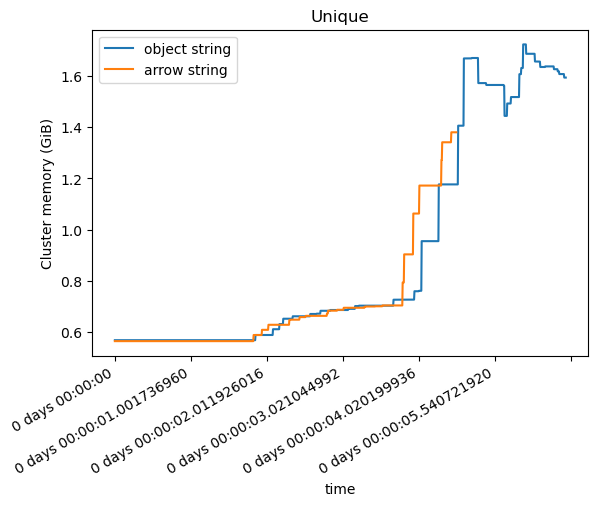

In [38]:
ms1.plot(align=True, title="Unique")

## Benchmark 2

In [39]:
client.restart();

In [40]:
# 2
with performance_report(filename=f"{report_dir}/2-object-group-count.html"):
    with ms2.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).groupby("store_and_fwd_flag").count().compute()
            # time.sleep(0.2)

In [44]:
client.restart();

In [45]:
# 2, ddf2
with performance_report(filename=f"{report_dir}/2-string-group-count.html"):
    with ms2.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).groupby("store_and_fwd_flag").count().compute()
            # time.sleep(0.2)

<Axes: title={'center': 'Groupby/count'}, xlabel='time', ylabel='Cluster memory (GiB)'>

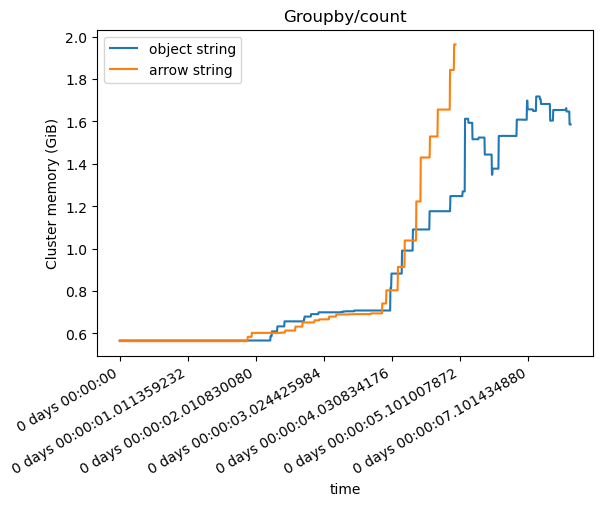

In [46]:
ms2.plot(align=True, title="Groupby/count")

## Benchmark 3

In [47]:
client.restart();

In [48]:
# 3
with performance_report(filename=f"{report_dir}/3-object-startswith.html"):
    with ms3.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).store_and_fwd_flag.str.startswith("a").compute()
            # time.sleep(0.2)

In [49]:
client.restart();

In [50]:
# 3, ddf2
with performance_report(filename=f"{report_dir}/3-string-startswith.html"):
    with ms3.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2(True).store_and_fwd_flag.str.startswith("a").compute()
            # time.sleep(0.2)

<Axes: title={'center': 'String startswith'}, xlabel='time', ylabel='Cluster memory (GiB)'>

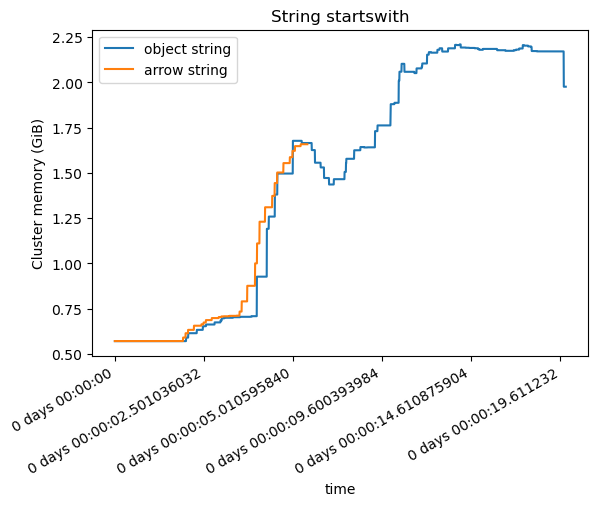

In [51]:
ms3.plot(align=True, title="String startswith")

## Benchmark 4

In [61]:
client.restart();

In [62]:
# 4
with performance_report(filename=f"{report_dir}/4-object-strlen.html"):
    with ms4.sample("object string", interval=0.01):
        for _ in range(1):
            get_ddf(True).store_and_fwd_flag.str.len().compute()
            # time.sleep(0.2)

In [63]:
client.restart();

In [64]:
# 4, ddf2
with performance_report(filename=f"{report_dir}/4-string-strlen.html"):
    with ms4.sample("arrow string", interval=0.01):
        for _ in range(1):
            get_ddf2().store_and_fwd_flag.str.len().compute()
            # time.sleep(0.2)

<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

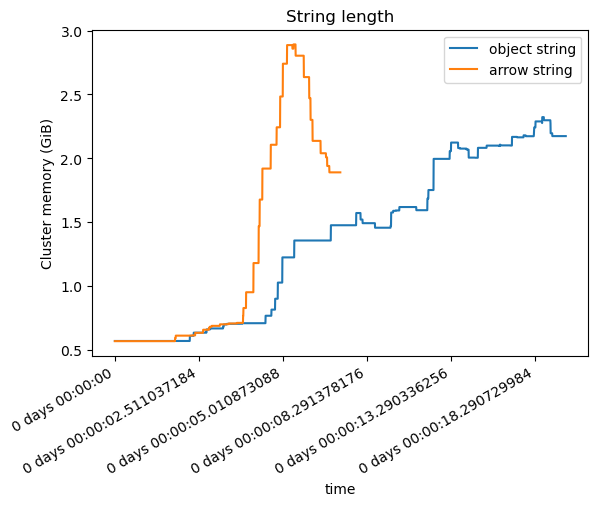

In [65]:
ms4.plot(align=True, title="String length")

In [66]:
client.close()

In [67]:
cluster.close()